<a href="https://colab.research.google.com/github/HariniJeyashree/google-trends-data-science-skill-demand/blob/main/search_trend_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Hiring trends in data science are rapidly evolving. Instead of focusing only on job titles,
organizations increasingly prioritize specific skills such as AI tools and machine learning.

This project analyzes Google search interest data to understand:
- How demand for Data Scientist jobs compares to AI tools and ML learning
- Whether skill-learning interest precedes job-search interest
- What this signals for future hiring trends

Data Source: Google Trends (via PyTrends API)
Timeframe: Past 5 years


## Data Collection

Google Trends provides normalized search interest (0–100), not absolute counts.
The data is sampled and represents relative popularity over time.


In [ ]:
!pip install pytrends pandas matplotlib


In [ ]:
from pytrends.request import TrendReq
import pandas as pd


In [ ]:
pytrends = TrendReq(hl='en-US', tz=330)

keywords = [
    "Data Scientist Jobs",
    "AI Tools",
    "Machine Learning Course"
]

pytrends.build_payload(
    keywords,
    timeframe='today 5-y',
    geo=''
)

data = pytrends.interest_over_time()
data.head()


/usr/local/lib/python3.12/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,Data Scientist Jobs,AI Tools,Machine Learning Course,isPartial
date,,,,
2021-01-03,1,0,0,False
2021-01-10,1,0,1,False
2021-01-17,1,0,1,False
2021-01-24,1,0,0,False
2021-01-31,1,0,1,False


In [ ]:
data = data.drop(columns=['isPartial'])


## Data Understanding

The dataset contains weekly or monthly normalized interest scores.
Missing values may occur due to low search volume or sampling.


In [ ]:
data = data.reset_index()
data.head()


,date,Data Scientist Jobs,AI Tools,Machine Learning Course
0,2021-01-03,1,0,0
1,2021-01-10,1,0,1
2,2021-01-17,1,0,1
3,2021-01-24,1,0,0
4,2021-01-31,1,0,1


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     262 non-null    datetime64[ns]
 1   Data Scientist Jobs      262 non-null    int64         
 2   AI Tools                 262 non-null    int64         
 3   Machine Learning Course  262 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 8.3 KB


In [ ]:
data.describe()


,date,Data Scientist Jobs,AI Tools,Machine Learning Course
count,262,262.000000,262.000000,262.000000
mean,2023-07-05 12:00:00,1.007634,11.702290,1.045802
min,2021-01-03 00:00:00,1.000000,0.000000,0.000000
25%,2022-04-04 18:00:00,1.000000,0.000000,1.000000
50%,2023-07-05 12:00:00,1.000000,7.000000,1.000000
75%,2024-10-04 06:00:00,1.000000,10.750000,1.000000
max,2026-01-04 00:00:00,2.000000,100.000000,3.000000
std,NaN,0.087203,19.520181,0.508361


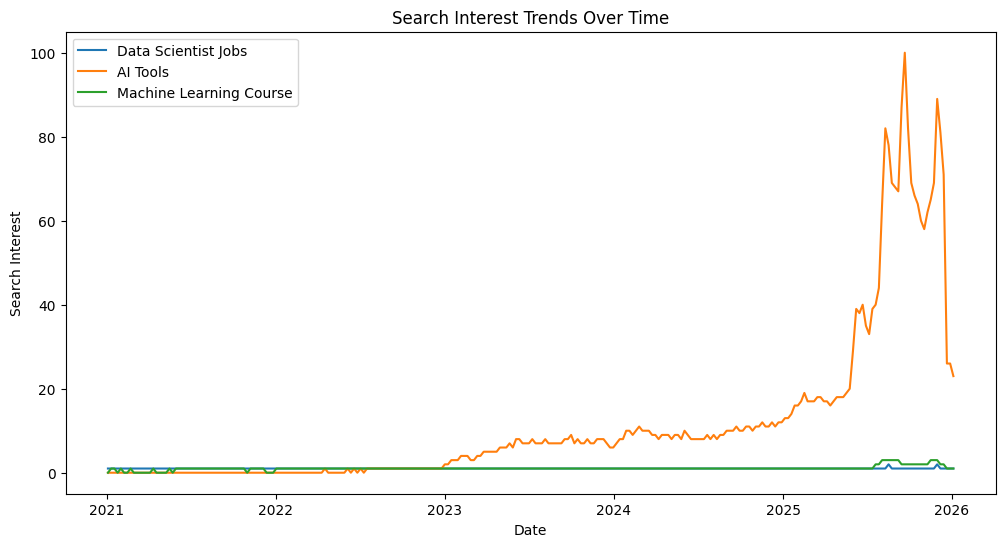

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(data['date'], data['Data Scientist Jobs'], label='Data Scientist Jobs')
plt.plot(data['date'], data['AI Tools'], label='AI Tools')
plt.plot(data['date'], data['Machine Learning Course'], label='Machine Learning Course')

plt.xlabel("Date")
plt.ylabel("Search Interest")
plt.title("Search Interest Trends Over Time")
plt.legend()
plt.show()


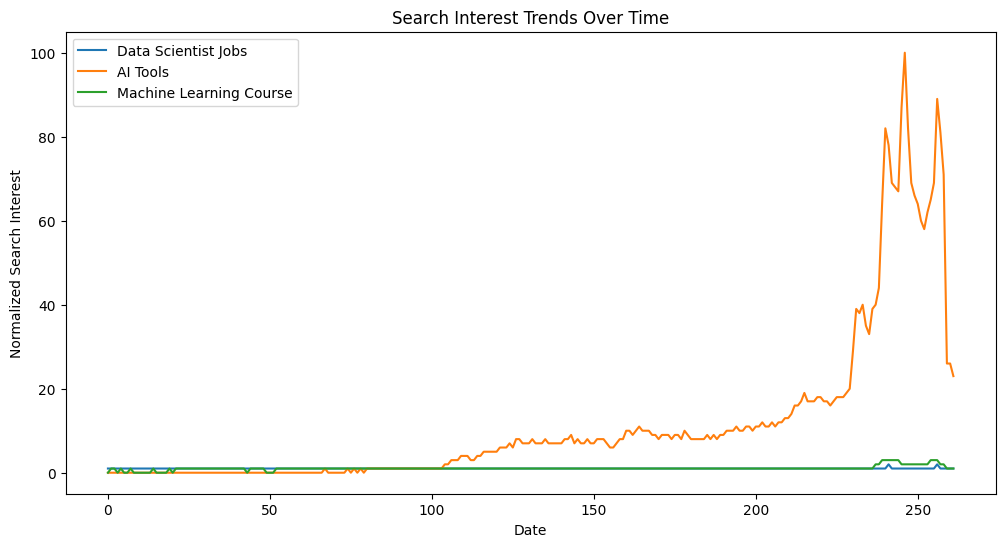

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for col in keywords:
    plt.plot(data.index, data[col], label=col)

plt.title("Search Interest Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Search Interest")
plt.legend()
plt.show()

## Trend Smoothing

Moving averages help highlight long-term trends by reducing short-term noise.


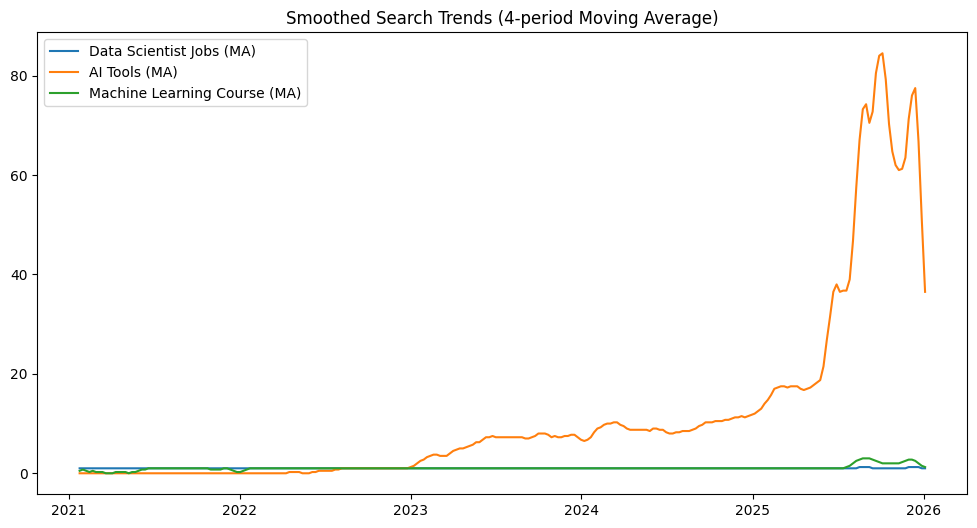

In [ ]:
for col in keywords:
    data[f"{col}_MA"] = data[col].rolling(window=4).mean()

plt.figure(figsize=(12,6))
for col in keywords:
    plt.plot(data['date'], data[f"{col}_MA"], label=f"{col} (MA)")

plt.title("Smoothed Search Trends (4-period Moving Average)")
plt.legend()
plt.show()


In [ ]:
correlation = data[keywords].corr()
correlation


,Data Scientist Jobs,AI Tools,Machine Learning Course
Data Scientist Jobs,1.000000,0.323211,0.337797
AI Tools,0.323211,1.000000,0.789803
Machine Learning Course,0.337797,0.789803,1.000000


In [ ]:
data[keywords].describe()


,Data Scientist Jobs,AI Tools,Machine Learning Course
count,262.000000,262.000000,262.000000
mean,1.007634,11.702290,1.045802
std,0.087203,19.520181,0.508361
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,1.000000,7.000000,1.000000
75%,1.000000,10.750000,1.000000
max,2.000000,100.000000,3.000000


In [ ]:
data[keywords].pct_change().mean()


,0
Data Scientist Jobs,0.003831
AI Tools,inf
Machine Learning Course,inf


In [ ]:
intent_map = {
    "Data Scientist Jobs": "Transactional",
    "Machine Learning Course": "Transactional",
    "AI Tools": "Informational"
}

intent_df = pd.DataFrame(list(intent_map.items()), columns=["Keyword", "Intent"])
intent_df


,Keyword,Intent
0,Data Scientist Jobs,Transactional
1,Machine Learning Course,Transactional
2,AI Tools,Informational


## Time Series Decomposition

Decomposing trends into:
- Trend
- Seasonality
- Residuals


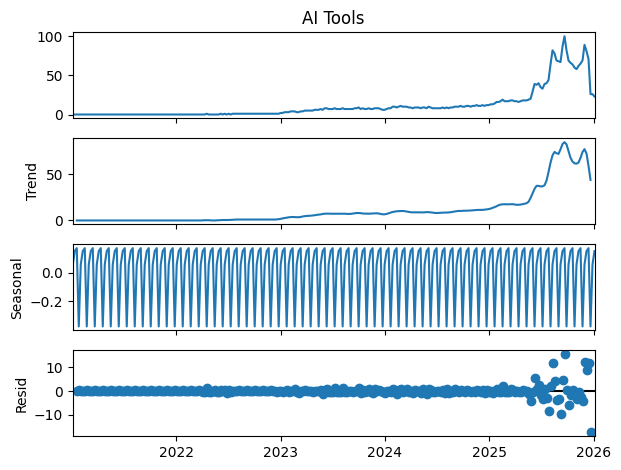

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = data.set_index('date')['AI Tools']

decomposition = seasonal_decompose(series, model='additive', period=4)

decomposition.plot()
plt.show()


In [ ]:
growth_rates = data[keywords].pct_change().rolling(4).mean()
growth_rates.tail()


,Data Scientist Jobs,AI Tools,Machine Learning Course
257,0.125,0.077473,0.041667
258,0.125,0.034512,-0.083333
259,0.125,-0.139323,-0.208333
260,-0.125,-0.211787,-0.208333
261,0.000,-0.218161,-0.125000


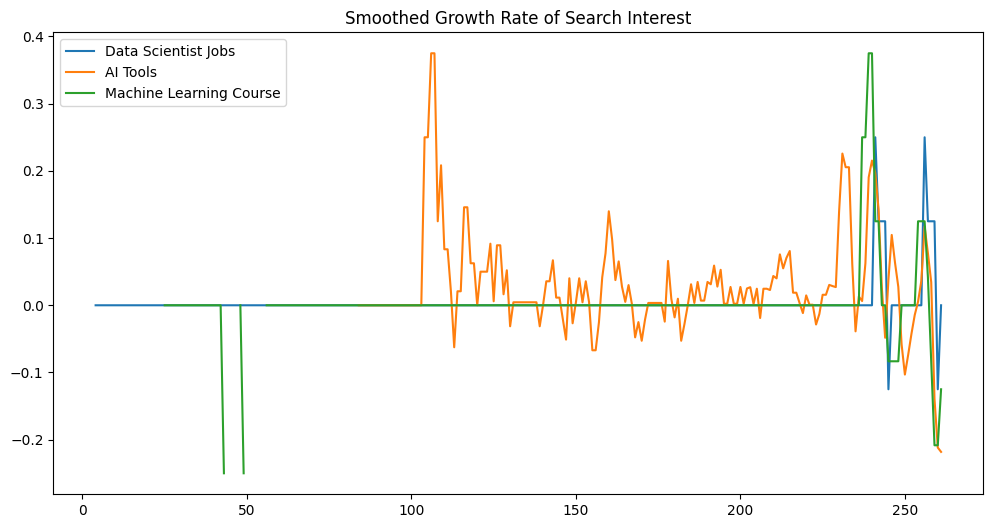

In [ ]:
growth_rates.plot(figsize=(12,6))
plt.title("Smoothed Growth Rate of Search Interest")
plt.show()


## Lead–Lag Analysis

Does interest in learning precede job demand?


In [ ]:
data['ML_leads_DS'] = data['Machine Learning Course'].shift(2)

data[['ML_leads_DS', 'Data Scientist Jobs']].corr()


,ML_leads_DS,Data Scientist Jobs
ML_leads_DS,1.000000,0.337756
Data Scientist Jobs,0.337756,1.000000


In [ ]:
region_data = pytrends.interest_by_region(resolution='COUNTRY')
region_data.sort_values(by='AI Tools', ascending=False).head(10)


,Data Scientist Jobs,AI Tools,Machine Learning Course
geoName,,,
Philippines,4,94,2
Indonesia,2,93,5
Japan,2,92,6
Malaysia,5,90,5
Poland,3,90,7
Brazil,3,89,8
Netherlands,5,89,6
Taiwan,3,89,8
Finland,5,88,7


## Forecasting Future Demand

Forecasting allows us to estimate future trends based on historical search behavior.
This can help platforms, recruiters, and learners anticipate demand shifts.


In [ ]:
ts = data[['date', 'AI Tools']].copy()
ts = ts.set_index('date')
ts.head()


,AI Tools
date,
2021-01-03,0
2021-01-10,0
2021-01-17,0
2021-01-24,0
2021-01-31,0


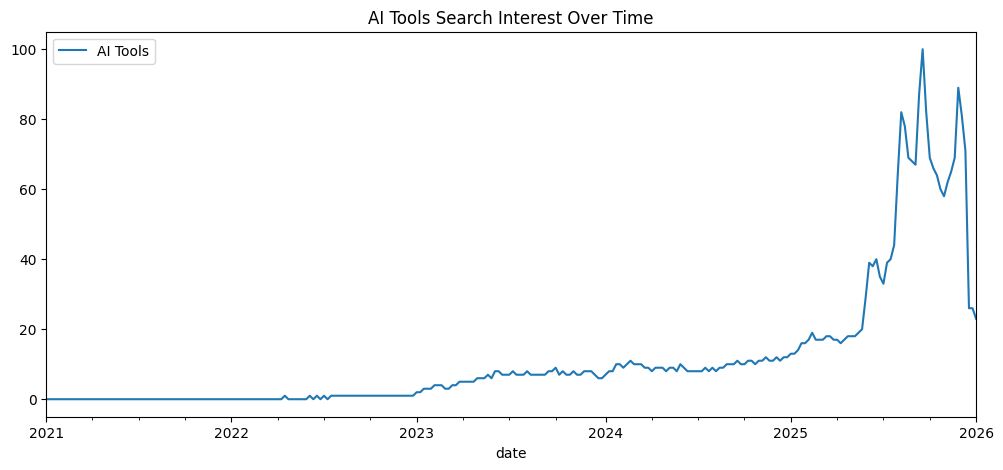

In [ ]:
ts.plot(figsize=(12,5), title="AI Tools Search Interest Over Time")
plt.show()


In [ ]:
train = ts.iloc[:-8]   # all except last ~2 months
test = ts.iloc[-8:]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [ ]:
forecast = model_fit.forecast(steps=12)
forecast

,predicted_mean
2025-11-16,64.030698
2025-11-23,63.689717
2025-11-30,63.746972
2025-12-07,63.737358
2025-12-14,63.738973
2025-12-21,63.738702
2025-12-28,63.738747
2026-01-04,63.738740
2026-01-11,63.738741
2026-01-18,63.738741


In [ ]:
rolling_preds = []
rolling_true = []

train = ts.iloc[:-12]
test = ts.iloc[-12:]

for i in range(len(test)):
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit()
    pred = model_fit.forecast()[0]
    rolling_preds.append(pred)
    train = pd.concat([train, test.iloc[i:i+1]])
    rolling_true.append(test.iloc[i, 0])


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-880120000.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = model_fit.forecast()[0]
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Va

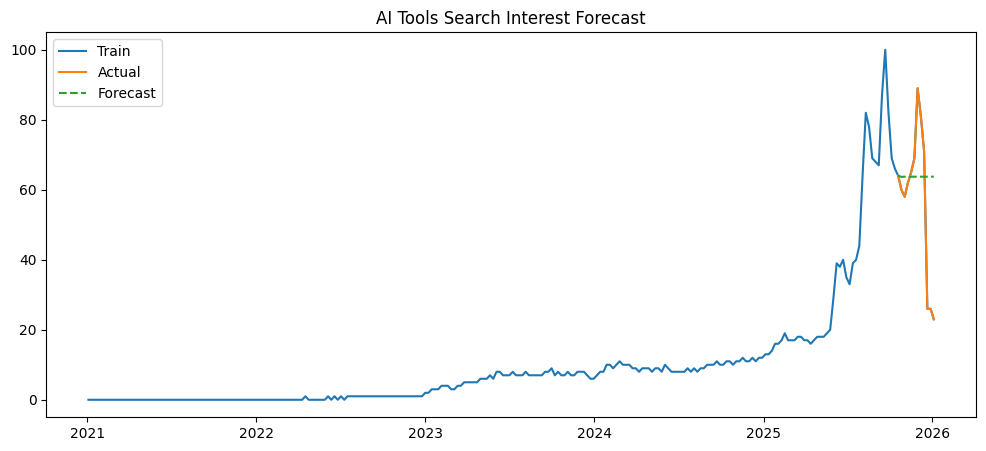

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')

plt.title("AI Tools Search Interest Forecast")
plt.legend()
plt.show()


## Forecast Interpretation

The model predicts a continued upward trend in interest for AI tools.
This suggests sustained or increasing adoption of AI technologies,
supporting the hypothesis of skill-first hiring trends.


## Forecasting Limitations

- ARIMA assumes linear trends
- Google Trends data is normalized and sampled
- External shocks (news, releases) are not captured


## Business & Career Implications

- Rising AI tool interest suggests skill-first hiring
- Learning demand often leads hiring cycles
- Education platforms can align course launches with demand peaks
- Job seekers should track skill trends, not only job titles


## Limitations

- Google Trends provides normalized, sampled data
- Search interest ≠ actual hiring volume
- Results depend on keyword selection


## Conclusion

Google Trends data indicates a structural shift from role-based hiring
toward skill-based evaluation, with AI tools and ML learning gaining momentum
ahead of job search interest.


In [ ]:
data.to_csv("google_trends_data_science_analysis.csv", index=False)



In [ ]:
!ls


google_trends_data_science_analysis.csv  search_trends_analysis.csv
sample_data


In [ ]:
from google.colab import files

files.download("search_trends_analysis.csv")
files.download("google_trends_data_science_analysis.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>